# Setup

In [104]:
import pandas as pd
from ita_deidentification import anonymizer
from os import path, listdir
from collections import defaultdict

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
test_folder_path = './anonymisation_letters/'
deid = anonymizer('./config.json')


DOWNLOADING AND INITIALIZING MODELS --------------------------------------------


2022-11-20 16:55:21 INFO: Downloading default packages for language: it (Italian) ...
2022-11-20 16:55:22 INFO: File exists: /home/serna/stanza_resources/it/default.zip
2022-11-20 16:55:25 INFO: Finished downloading models and saved to /home/serna/stanza_resources.
2022-11-20 16:55:25 INFO: Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


2022-11-20 16:55:25 WARNING: Language it package default expects mwt, which has been added
2022-11-20 16:55:25 INFO: Loading these models for language: it (Italian):
| Processor | Package  |
------------------------
| tokenize  | combined |
| mwt       | combined |
| ner       | fbk      |

2022-11-20 16:55:25 INFO: Use device: gpu
2022-11-20 16:55:25 INFO: Loading: tokenize
2022-11-20 16:55:27 INFO: Loading: mwt
2022-11-20 16:55:27 INFO: Loading: ner
2022-11-20 16:55:28 INFO: Done loading processors!


In [77]:
def compute_scores(predictions, targets, confusion_only=False):
    tp = 0
    fp = 0
    fn = 0
    targets = targets.copy()
    for prediction in predictions:
        if prediction in targets:
            tp += 1
            targets.remove(prediction)
        else:
            fp += 1
    fn += len(targets)
    
    precision = tp / (tp + fp) if tp + fp > 0 else 0
    recall = tp / (tp + fn) if tp + fn > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if precision + recall > 0 else 0
    if confusion_only:
        return { 'tp': tp, 'fp': fp, 'fn': fn }
    else:
        return { 'precision': precision, 'recall': recall, 'f1': f1 }


def compute_scores_document(df_predictions, df_targets):
    # strict calculation
    df_predictions['strict_pos'] = df_predictions.start.astype(str) + '-' + df_predictions.end.astype(str)
    df_targets['strict_pos'] = df_targets.start.astype(str) + '-' + df_targets.end.astype(str)

    strict_scores_dict = {}
    for entity_type in df_targets.entity_type.unique():
        strict_scores_dict[entity_type] = compute_scores(df_predictions.loc[df_predictions.entity_type == entity_type,'strict_pos'].to_list(), df_targets.loc[df_targets.entity_type == entity_type, 'strict_pos'].to_list())

    # lenient calculation
    def overlap(a, b):
        if max(0, min(a[1], b[1]) - max(a[0], b[0])) != 0:
            return True
        else:
            return False

    lenient_scores_dict = {}
    for entity_type in df_targets.entity_type.unique():
        # print('compute score for entity_type:', entity_type)
        prediction_lenient_match = []
        for pred_index, prediction in df_predictions.loc[df_predictions.entity_type == entity_type].iterrows():
            for target_index, target in df_targets.loc[df_targets.entity_type == entity_type].iterrows():
                prediction_pos = [prediction['start'], prediction['end']]
                target_pos = [target['start'], target['end']]
                if overlap(prediction_pos, target_pos):
                    prediction_lenient_match.append(target_index)
        
        prediction_lenient_match = list(set(prediction_lenient_match))

        prediction_lenient_match = prediction_lenient_match + [None] * (len(df_predictions.loc[df_predictions.entity_type == entity_type]) - len(prediction_lenient_match))
        # print('prediction_lenient_match:', prediction_lenient_match)
        # print('target indexes', df_targets.index[df_targets.entity_type == entity_type].tolist())
        lenient_scores_dict[entity_type] = compute_scores(
            prediction_lenient_match,
            df_targets.index[df_targets.entity_type == entity_type].tolist()
        )

    return {'strict': strict_scores_dict, 'lenient': lenient_scores_dict}

In [78]:
test_filename_text_list = [filename for filename in listdir(test_folder_path) if '.txt' in filename and '_' not in filename]
test_filename_text_list.sort()
test_filename_anon_list = [filename for filename in listdir(test_folder_path) if 'anon.csv' in filename]
test_filename_anon_list.sort()

In [74]:
# df_prova = pd.DataFrame()
# for filename in test_filename_anon_list:
#     df_tmp = pd.read_csv(test_folder_path + filename, sep=';', names=['start', 'end', 'entity_type'])
#     # print(df_tmp.head())
#     # break
#     df_prova = pd.concat([df_prova, df_tmp])
# list(df_prova.entity_type.unique())

['NAME', 'DATE', 'LOC', 'AGE', 'YEAR', 'ORG', 'TEL']

# Evaluation of all documents

In [120]:
index_named_entity = [
    'TEL',
    'ZIP',
    'EMAIL',
    'NAME',
    'ORG',
    'LOC',
    'DATE',
    'CF',
    'AGE'
]
corpus_scores_lenient_dict = {key: dict(precision=[], recall=[], f1=[]) for key in index_named_entity}
corpus_scores_strict_dict = {key: dict(precision=[], recall=[], f1=[]) for key in index_named_entity}
for filename_anon, filename_text in zip(test_filename_anon_list, test_filename_text_list):
    # load text
    with open(test_folder_path + filename_text, 'r') as file:
        text = ''.join(file.readlines())
    # perform inference and retrieve spans
    output_dict = deid.deIdentificationIta(text)
    # create a dataframe with start, end, entity_type, text as columns
    df_predictions = pd.DataFrame()
    for entity_type in output_dict['spans_dict']:
        
        start_list = [int(pos[0]) for pos in output_dict['spans_dict'][entity_type]]
        end_list = [int(pos[1]) for pos in output_dict['spans_dict'][entity_type]]
        text_list = [text[int(pos[0]):int(pos[1])] for pos in output_dict['spans_dict'][entity_type]]

        df_tmp = pd.DataFrame(
            {
                'start': start_list,
                'end': end_list,
                'entity_type': [entity_type]*len(start_list),
                'text': text_list
            }
        )
        df_predictions = pd.concat([df_predictions, df_tmp])

    df_predictions.start = df_predictions.start.astype(int)
    df_predictions.end = df_predictions.end.astype(int)

    df_predictions.reset_index(drop=True, inplace=True)
    # change names of the entity_types to be consistent with targets entity_types
    df_predictions['entity_type'] = df_predictions['entity_type'].replace(
        [
            'telephone',
            'zipcode',
            'email',
            'person',
            'organization',
            'address',
            'date',
            'fiscal_code',
            'age'
        ],
        [
            'TEL',
            'ZIP',
            'EMAIL',
            'NAME',
            'ORG',
            'LOC',
            'DATE',
            'CF',
            'AGE'
        ]
    )
    
    # load the gold standard annotations
    df_targets = pd.read_csv(test_folder_path + filename_anon, sep=';', names=['start', 'end', 'entity_type'])
    df_targets['text'] = df_targets.apply(lambda row: text[row['start']:row['end']], axis=1)
    df_targets['entity_type'] = df_targets['entity_type'].replace(
        [
            'YEAR'
        ],
        [
            'DATE'
        ]
    )

    # compute the scores of the single document
    scores_dict = compute_scores_document(df_predictions, df_targets)
    
    # insert the lenient scores in a aggregated list
    for entity_type in scores_dict['lenient']:
        for score_type in ['precision','recall', 'f1']:
            corpus_scores_lenient_dict[entity_type][score_type].append(scores_dict['lenient'][entity_type][score_type])
    # insert the strict scores in a aggregated list
    for entity_type in scores_dict['strict']:
        for score_type in ['precision','recall', 'f1']:
            corpus_scores_strict_dict[entity_type][score_type].append(scores_dict['strict'][entity_type][score_type])

# create the dataframe of the scores of the corpus
df_corpus_scores_lenient = pd.DataFrame(index=index_named_entity, columns=['precision', 'recall', 'f1'])
df_corpus_scores_strict = pd.DataFrame(index=index_named_entity, columns=['precision', 'recall', 'f1'])

# compute the avg of the scores: correspond to a macro average 
for entity_type in index_named_entity:
    for score_type in ['precision','recall', 'f1']:

        score_list_lenient = corpus_scores_lenient_dict[entity_type][score_type]
        if score_list_lenient != []:
            df_corpus_scores_lenient.loc[entity_type, score_type] = sum(score_list_lenient)/len(score_list_lenient)

        score_list_strict = corpus_scores_strict_dict[entity_type][score_type]
        if score_list_strict != []:
            df_corpus_scores_strict.loc[entity_type, score_type] = sum(score_list_strict)/len(score_list_strict)

# drop entity types that never appears 
df_corpus_scores_lenient.dropna(inplace=True)
df_corpus_scores_strict.dropna(inplace=True)

df_corpus_scores_lenient.recall = df_corpus_scores_lenient.recall.astype(float)
df_corpus_scores_lenient.precision = df_corpus_scores_lenient.precision.astype(float)
df_corpus_scores_lenient.f1 = df_corpus_scores_lenient.f1.astype(float)

df_corpus_scores_strict.recall = df_corpus_scores_strict.recall.astype(float)
df_corpus_scores_strict.precision = df_corpus_scores_strict.precision.astype(float)
df_corpus_scores_strict.f1 = df_corpus_scores_strict.f1.astype(float)
    

<AxesSubplot: >

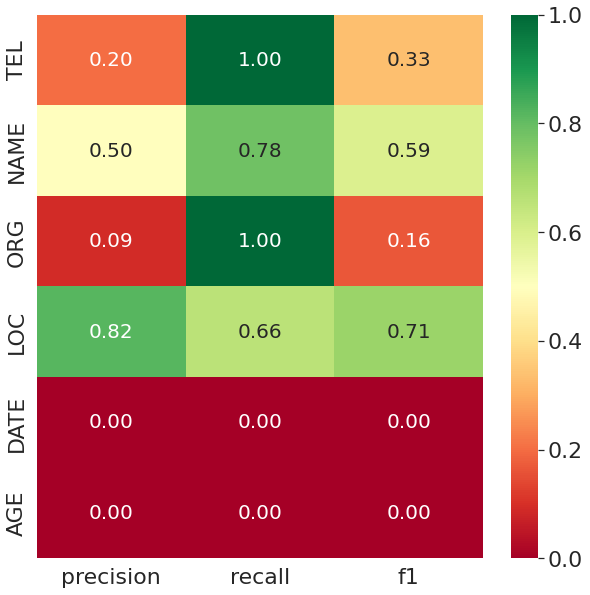

In [121]:
# plot the heatmap of the lenient scores
sns.set(font_scale=2)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(df_corpus_scores_lenient, cmap='RdYlGn', annot=True, fmt=".2f", annot_kws={"fontsize":20}, vmin=0, vmax=1)
# fig.savefig(f'QUESTIONS_heat.png', dpi=400, transparent=True, bbox_inches='tight')

<AxesSubplot: >

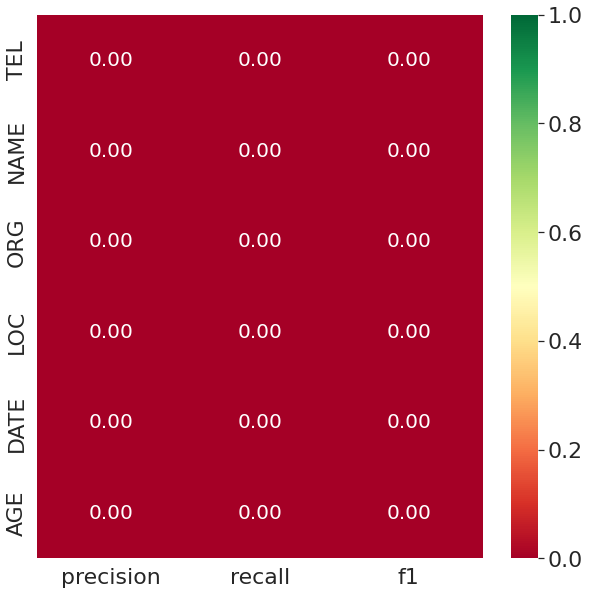

In [122]:
# plot the heatmap of the lenient scores
sns.set(font_scale=2)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(df_corpus_scores_strict, cmap='RdYlGn', annot=True, fmt=".2f", annot_kws={"fontsize":20}, vmin=0, vmax=1)
# fig.savefig(f'QUESTIONS_heat.png', dpi=400, transparent=True, bbox_inches='tight')

# evaluation of one document

In [79]:
with open(test_folder_path + test_filename_text_list[0], 'r') as file:
    text = ''.join(file.readlines())

In [80]:
output_dict = deid.deIdentificationIta(text)

In [81]:
df_predictions = pd.DataFrame()
for entity_type in output_dict['spans_dict']:
    start_list = [int(pos[0]) for pos in output_dict['spans_dict'][entity_type]]
    end_list = [int(pos[1]) for pos in output_dict['spans_dict'][entity_type]]
    text_list = [text[int(pos[0]):int(pos[1])] for pos in output_dict['spans_dict'][entity_type]]
    df_tmp = pd.DataFrame({'start': start_list, 'end': end_list, 'entity_type': [entity_type]*len(start_list), 'text': text_list})
    df_predictions = pd.concat([df_predictions, df_tmp])

In [82]:
df_predictions.start = df_predictions.start.astype(int)
df_predictions.end = df_predictions.end.astype(int)

In [83]:
df_predictions.reset_index(drop=True, inplace=True)

In [84]:
df_predictions['entity_type'] = df_predictions['entity_type'].replace(
    [
        'telephone',
        'zipcode',
        'email',
        'person',
        'organization',
        'address',
        'date',
        'fiscal_code',
        'age'
    ],
    [
        'TEL',
        'ZIP',
        'EMAIL',
        'NAME',
        'ORG',
        'LOC',
        'DATE',
        'CF',
        'AGE'
    ]
)

In [85]:
df_predictions

,start,end,entity_type,text
0,53,63,TEL,19.02.1964
1,107,117,TEL,28.07.2021
2,403,413,TEL,19.07.2021
3,5390,5400,TEL,25.07.2021
4,5403,5413,TEL,27.07.2021
5,6781,6791,TEL,08.04.1988
6,7582,7587,ZIP,24457
7,32,43,NAME,Marta Rossi
8,325,336,NAME,Marta Rossi
9,1252,1258,NAME,Biondi


In [86]:
df_targets = pd.read_csv(test_folder_path + test_filename_anon_list[0], sep=';', names=['start', 'end', 'entity_type'])

In [96]:
df_targets['text'] = df_targets.apply(lambda row: text[row['start']:row['end']], axis=1)

df_targets['entity_type'] = df_targets['entity_type'].replace(
    [
        'YEAR'
    ],
    [
        'DATE'
    ]
)


In [97]:
df_targets

,start,end,entity_type,text,strict_pos
0,32,42,NAME,Marta Ross,32-42
1,53,62,DATE,19.02.196,53-62
2,77,95,LOC,San Donato Milanes,77-95
3,98,103,LOC,Milan,98-103
4,107,116,DATE,28.07.202,107-116
5,273,277,LOC,\nAos,273-277
6,323,333,NAME,a Marta Ro,323-333
7,339,345,AGE,i anni,339-345
8,401,410,DATE,a 19.07.2,401-410
9,989,998,DATE,o 24/05/2,989-998


In [98]:
scores_dict = compute_scores_document(df_predictions, df_targets)

In [100]:
index_named_entity = [
    'TEL',
    'ZIP',
    'EMAIL',
    'NAME',
    'ORG',
    'LOC',
    'DATE',
    'CF',
    'AGE'
]

df_scores = pd.DataFrame(index=index_named_entity, columns=['precision', 'recall', 'f1'])
for entity_type in scores_dict['lenient']:
    df_scores.loc[entity_type, 'recall'] = scores_dict['lenient'][entity_type]['recall']
    df_scores.loc[entity_type, 'precision'] = scores_dict['lenient'][entity_type]['precision']
    df_scores.loc[entity_type, 'f1'] = scores_dict['lenient'][entity_type]['f1']

In [101]:
df_scores.dropna(inplace=True)

In [102]:
df_scores.recall = df_scores.recall.astype(float)
df_scores.precision = df_scores.precision.astype(float)
df_scores.f1 = df_scores.f1.astype(float)

<AxesSubplot: >

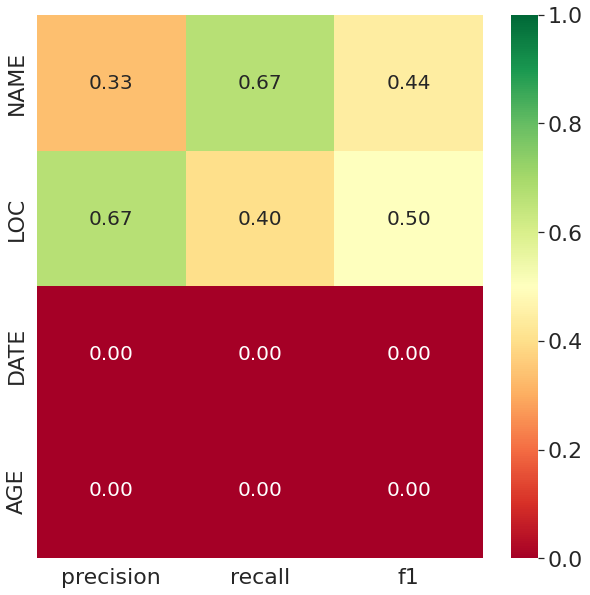

In [103]:
sns.set(font_scale=2)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(df_scores, cmap='RdYlGn', annot=True, fmt=".2f", annot_kws={"fontsize":20}, vmin=0, vmax=1)
# fig.savefig(f'QUESTIONS_heat.png', dpi=400, transparent=True, bbox_inches='tight')